<a href="https://colab.research.google.com/gist/marcfrincu/cbfcf0f38af0766025180297a0077955/loading_and_clean_smart_grid_consumption_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading and cleaning raw smart grid data

We are all used to working with *clean data*. Whether for a school project or at work with a dataset taken from the Internet. The problem is that those clean datasets are produced after a long process from *raw data* taken by smart meters and transmitted over the Internet to a database storage system part of an integrated system. Raw data is *full of errors* as systems (processing, storage, and transmission) are not perfect.

In this tutorial I will show **how raw smart meter is loaded into a dataframe and its contents is analyzed and errors are fixed** producing a clean dataset ready to be analyzed. 

Running the example requires several **libraries**:

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from google.colab import files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The **first step** is to **get the raw data** as exported from the smart meter data repository. In our example, the data is exported as a **csv file** with **three columns**: **datetime stamp**, **total consumed energy**, and **consumed energy from the last reading**. Each entry is separated by a semicolon ;. The energy is read every 15 minutes starting on the hour (00, 15, 30, 45) and each file contains the data for one smart meter.

Next we will **upload** a file called test.csv in the above format and **read its content in a dataframe**.

Saving test.csv to test.csv
User uploaded file "test.csv" with length 1709244 bytes


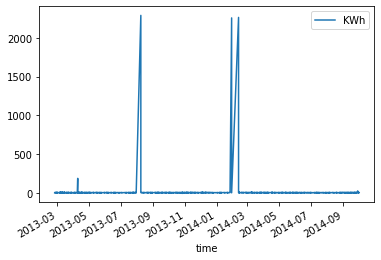

In [2]:
#!rm "test.csv"

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
    name=fn, length=len(uploaded[fn])))
  
raw_df = pd.read_csv('test.csv',';')

# We must convert the text in the csv to datetime format
raw_df['time']= pd.to_datetime(raw_df['time'], infer_datetime_format=True)

# Plot the raw data
raw_df.plot(x = 'time', y = 'KWh')

The **firs row contains the column names** which we can visualize by running:

In [3]:
print (raw_df.columns)

Index(['time', 'totalKWh', 'KWh'], dtype='object')


Now that the data is loaded we can proceed to **clean** it by **removing the outliers**, **duplicates**, and **fix missing data**. *The order of these operations is important* as each step can generate invalid data which was taken care before earlier.

# Step 1: Remove the outliers

Datasets can contain outlier, values which do not fit the general pattern of the overall data. For instance if the smart meter data has values in the [0,5] KWh range, having a reading with values as high as 100 is strange and should be treated carefully. Usually these are outliers so they should be removed.

It is important to note that these outliers are not always bugs in the data collection system but rather derive from its normal operation. Let us see the following example showing three consecutive meter readings:

*   1.26.14 22:30;	1,835,239.35;	2.6
*   **1.*26*.14 22:45**;	1,835,241.97;	2.62
*   **1.*29*.14 23:59**;	1,837,500.00;	**2258.03**

We notice the value 2258.03 following the 2.62 KWh reading. This may initially seem like a bug attributed to an erroneous reading but if we carefully analyze the time stamps we see that there is a gap of over 3 days between the two readings. As the column shows the difference between consecutive readings it is natural to have a large value accounting for the 3 days. Nonetheless it represents an outlier which must be removed.

Outliers can be removed by using the **Z-score** and eliminating any value less than -3 or greater than 3. The reason for that is that the empirical rule tells us that any data should be within 3 standard deviations from the mean.

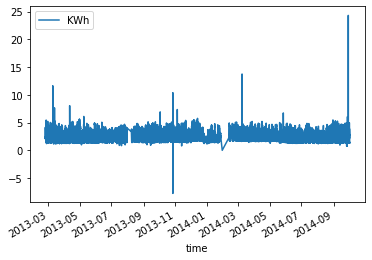

In [4]:
# Compute Z score and remove outliers, Z score > 3
z_scores = pd.DataFrame(stats.zscore(raw_df['KWh']))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

filtered_df = raw_df[filtered_entries]

# Plot data without outliers
filtered_df.plot(x = 'time', y = 'KWh')

We note in the previous plot that removing the outliers has emphasized some **negative values**. Such values are incorrect as you cannot have a negative energy consumption reading. These can be easily removed as well as shown next:

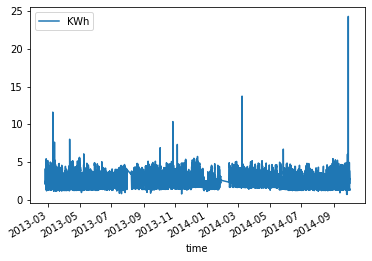

In [5]:
# Remove any negatives
filtered_df = filtered_df[filtered_df['KWh'] > 0] 

# Plot data without negatives
filtered_df.plot(x = 'time', y = 'KWh')

# Step 2: Remove duplicates

Sometimes the same reading can get inserted into the database leading to cases such as the one below:



*   **02.12.2014 08:45**;	1839780.05;	3.6
*   **02.12.2014 08:45**;	1839780.05;	3.6

where we can notice that the two entries are identical. As we only need one we can safely discard the other.

Duplicates can be easily removed as shown next:

In [6]:
with_duplicates_count = len(filtered_df)

filtered_df.drop_duplicates(subset = 'time', keep = 'first', inplace = True)

print('Removed ', with_duplicates_count - len(filtered_df), ' duplicates')

Removed  1  duplicates


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Step 3: Check for missing read KWh values and flag them

Due to **network communication issues** (among others) it is possible that sometimes reads at specific intervals are dropped as shown in the next example where the reading corresponding to the 02:00 time is missing:

*   03.06.2013 01:45;	1,754,862.46;	1.34
*   03.06.2013 02:15;	1,754,865.25;	2.79

To address this problem we will generate a dataframe (called here *complete_df*) containing a series of consecutive datatimes spaced at 15-min intervals between our first and last datetime stamp in the time series. Then we will merge this dataframe with our filtered dataframe (*filtered_df*). Missing values will appear (if any) as NaN in the second and third columns.


In [7]:
# Compute the difference between consecutive times
diff_list = abs(filtered_df['time'] - filtered_df['time'].shift()) / np.timedelta64(1, 's') # difference is in transformed in seconds

# Check if the difference is greater than 15 minutes
gaps_df = diff_list[diff_list > 15 * 60]

print('There are ', len(gaps_df), ' gaps in the dataset')

# The previous steps were just for displaying the the number of gaps and their sizes between consecutive reads. This is useful for an initial analysis of their number of occurances

# Next we create a new dataframe with all the indexes (times) and copy the values from the original dataframe here based on their indices
# Missing indices from the initial dataframe will have a NaN in the new dataframe

dates = pd.date_range(filtered_df['time'].iloc[0], filtered_df['time'].iloc[len(filtered_df)-1], freq="15T")

complete_df = pd.DataFrame(dates, columns=['time'])
complete_df.set_index = 'time'
complete_df['time'] = pd.to_datetime(complete_df['time'], infer_datetime_format=True)

# We can now merge the two dataframes
no_missing_vals_df = pd.merge(complete_df, filtered_df, on = 'time', how = 'outer')

# Show only the rows having NaN (missing values)
print(no_missing_vals_df[no_missing_vals_df['KWh'].isna()])

There are  24  gaps in the dataset
                     time  totalKWh  KWh
998   2013-03-06 02:00:00       NaN  NaN
1107  2013-03-07 05:15:00       NaN  NaN
1360  2013-03-09 20:30:00       NaN  NaN
1382  2013-03-10 02:00:00       NaN  NaN
1383  2013-03-10 02:15:00       NaN  NaN
...                   ...       ...  ...
39014 2014-04-06 02:00:00       NaN  NaN
39015 2014-04-06 02:15:00       NaN  NaN
39016 2014-04-06 02:30:00       NaN  NaN
39017 2014-04-06 02:45:00       NaN  NaN
43943 2014-05-27 10:15:00       NaN  NaN

[2540 rows x 3 columns]


# Step 4: Interpolate the missing values

Missing values must be interpreted and handled based on the analysis result. Gaps can occur due to **misread/misstored values** or due to the **smart meter being offline**. If the gaps are too large (days, months), due to the smart meter being offline, then they should be probably left like that and taken care of during the proper analysis. 

The gaps due to misreads/misstored can be handled in different ways, one being interpolation.

Next we will **interpolate** the values stored in the *no_missing_vals_df* dataframe and produce a final version of our ready to be analyzed dataset stored in the *interpolated_df* dataframe.

Empty DataFrame
Columns: [time, totalKWh, KWh]
Index: []
4.95


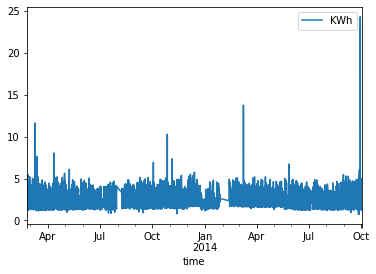

In [8]:
interpolated_df = no_missing_vals_df.interpolate()

# Sanity check which should output an empty dataframe
print(interpolated_df[interpolated_df['KWh'].isna()])

# Show that the previously NaN value on index 43943 (see previous code snippet) has been interpolated
print(interpolated_df['KWh'][43943])

interpolated_df.plot(x='time', y='KWh')

# Saving the cleaning dataframe to a csv file

Once the data has been cleaned it should be saved to a file for future processing. This can be done as shown next:

Index(['Unnamed: 0', 'time', 'totalKWh', 'KWh'], dtype='object')


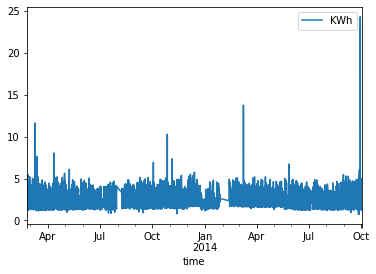

In [ ]:
interpolated_df.to_csv(r'test-cleaned.csv', header=True)

# Now load it again and plot its content. Notice that the initial separator ; (semicolon) has been replaced by a , (comma)
clean_df = pd.read_csv('test-cleaned.csv',',')

# You can either download the cleaned dataset like this or from the left pane unde 'Files'
#files.download('test-cleaned.csv')

print(clean_df.columns)

# We must convert the text in the csv to datetime format
clean_df['time']= pd.to_datetime(clean_df['time'], infer_datetime_format=True)

# Plot the raw data
clean_df.plot(x = 'time', y = 'KWh')

# Some final thoughts
## Zooming in a portion of the plot

The plots showing the data are quite dense due to the large volume of plotted KWh readings. This can be solved in various ways such as using a smaller dataset or **zooming** in a specific region of the plot. 

Zooming is a better choice for the analysis of the data as it is not always possible or feasible to split the data in smaller sets and process them independently.

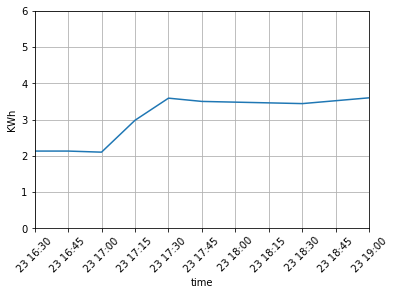

In [9]:
ax = plt.subplot(111) 
ax.set_xlim([interpolated_df['time'][0], interpolated_df['time'][10]])
ax.set_ylim([0, 6])
ax.plot(interpolated_df['time'], interpolated_df['KWh'])  
ax.grid()

plt.ylabel("KWh")
plt.xlabel("time")
plt.xticks(rotation=45)

plt.show()

# A complex scenario

Sometimes the data stored data reads produce interesting cases which must be carefully analyzed. Take for instance the next one:

1.   1.26.14 22:45;	1835241.97;	2.62
2.   1.29.14 **23:59**;	1837500;	**2258.03**
3.   1.30.14 **0:00**;	1837500;	**0**

Here we have the following problems:

*   On line 2 we have an outlier with a value of 2258.03
*   On line 3 we have a reading with a value of 0

By removing the outlier we end up with a nice timeseries spaced at 15-min intervals however the problem is not fully fixed as the 0 value follows from the fact that the reading took place immediately after the outlier (0:00 vs. 23:59). This means that the 0 value must be dealt with as well by removing it and then interpolating the new missing value. Finding such a case automatically is challenging as it depends on the scenario (the 0 value may in fact be real with all the appliances and othe consumers being offline). 

It is up to the data scientist to see these particular cases and address them accordingly.


## Changing the processing order

So far, the data cleaning process followed this order:

1.   Outlier removal (including negatives)
2.   Duplicate removal
3.   Find and flag missing values
4.   Interpolate missing values

*What happens if we change the order? Say we first find, flag and interpolate missing values and then remove outliers?*

Let us look at the next example which does just that (the code is identical with the previous snippets except the dataframes which have been updated to reflect the new scenario):


There are  25  gaps in the dataset
                     time  totalKWh  KWh
998   2013-03-06 02:00:00       NaN  NaN
1107  2013-03-07 05:15:00       NaN  NaN
1360  2013-03-09 20:30:00       NaN  NaN
1382  2013-03-10 02:00:00       NaN  NaN
1383  2013-03-10 02:15:00       NaN  NaN
...                   ...       ...  ...
39018 2014-04-06 02:00:00       NaN  NaN
39019 2014-04-06 02:15:00       NaN  NaN
39020 2014-04-06 02:30:00       NaN  NaN
39021 2014-04-06 02:45:00       NaN  NaN
43947 2014-05-27 10:15:00       NaN  NaN

[2536 rows x 3 columns]


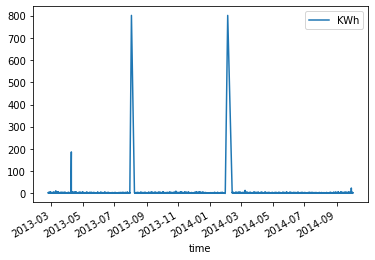

In [ ]:
##
# FIND, FLAG, INTERPOLATE MISSING VALUES
##

# Compute the difference between consecutive times
diff_list = abs(raw_df['time'] - raw_df['time'].shift()) / np.timedelta64(1, 's') # difference is in transformed in seconds

# Check if the difference is greater than 15 minutes
gaps_df = diff_list[diff_list > 15 * 60]

print('There are ', len(gaps_df), ' gaps in the dataset')

# The previous steps were just for displaying the the number of gaps and their sizes between consecutive reads. This is useful for an initial analysis of their number of occurances

# Next we create a new dataframe with all the indexes (times) and copy the values from the original dataframe here based on their indices
# Missing indices from the initial dataframe will have a NaN in the new dataframe

dates = pd.date_range(raw_df['time'].iloc[0], raw_df['time'].iloc[len(raw_df)-1], freq="15T")

complete_df = pd.DataFrame(dates, columns=['time'])
complete_df.set_index = 'time'
complete_df['time'] = pd.to_datetime(complete_df['time'], infer_datetime_format=True)

# We can now merge the two dataframes
no_missing_vals_df = pd.merge(complete_df, raw_df, on = 'time', how = 'outer')

# Show only the rows having NaN (missing values)
print(no_missing_vals_df[no_missing_vals_df['KWh'].isna()])

interpolated_df = no_missing_vals_df.interpolate()

# Sannity check which should output an empty dataframe
#print(interpolated_df[interpolated_df['KWh'].isna()])

# Show that the previously NaN value on index 43943 (see previous code snippet) has been interpolated
#print(interpolated_df['KWh'][43942])

#interpolated_df.plot(x='time', y='KWh')

##
# REMOVE OUTLIERS INCL. NEGATIVES
##

# Compute Z score and remove outliers, Z score > 3
z_scores = pd.DataFrame(stats.zscore(interpolated_df['KWh']))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

filtered_df = interpolated_df[filtered_entries]

# Plot data without outliers
#filtered_df.plot(x = 'time', y = 'KWh')

# Remove any negatives
filtered_df = filtered_df[filtered_df['KWh'] > 0] 

# Plot data without negatives
filtered_df.plot(x = 'time', y = 'KWh')

The plot above shows the time series after our cleaning. It can be seen that several outliers are still present. In addition there are several gaps in the series as we have removed outliers and negatives after interpolation which has produced some missing intervals. Compare it to the plot shown at Step 4.

This means we will have to interpolate again. We will not do that as it has already been shown before, but instead count the number of gaps:

In [ ]:
# Compute the difference between consecutive times
diff_list = abs(filtered_df['time'] - filtered_df['time'].shift()) / np.timedelta64(1, 's') # difference is in transformed in seconds

# Check if the difference is greater than 15 minutes
gaps_df = diff_list[diff_list > 15 * 60]

print('There are ', len(gaps_df), ' gaps in the dataset')

There are  3  gaps in the dataset


This concludes our short incursion into the world of smart grid raw data cleaning. My next example will show how you can perform some simple statistics on the data.